# GRAPE calculation of control fields for iSWAP implementation

Robert Johansson (robert@riken.jp)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
import numpy as np

In [2]:
from qutip import *
from qutip.control import *

In [3]:
T = 1
times = np.linspace(0, T, 100)

In [4]:
U = iswap()
R = 50
H_ops = [#tensor(sigmax(), identity(2)),
         #tensor(sigmay(), identity(2)),
         #tensor(sigmaz(), identity(2)),
         #tensor(identity(2), sigmax()),
         #tensor(identity(2), sigmay()),
         #tensor(identity(2), sigmaz()),
         tensor(sigmax(), sigmax()),
         tensor(sigmay(), sigmay()),
         tensor(sigmaz(), sigmaz())]

H_labels = [#r'$u_{1x}$',
            #r'$u_{1y}$',
            #r'$u_{1z}$',
            #r'$u_{2x}$',
            #r'$u_{2y}$',
            #r'$u_{2z}$',
            r'$u_{xx}$',
            r'$u_{yy}$',
            r'$u_{zz}$',
        ]

In [5]:
H0 = 0 * np.pi * (tensor(sigmaz(), identity(2)) + tensor(identity(2), sigmaz()))

# GRAPE

In [6]:
from qutip.control.grape import plot_grape_control_fields, _overlap, grape_unitary_adaptive, cy_grape_unitary

In [7]:
from scipy.interpolate import interp1d
from qutip.ui.progressbar import TextProgressBar

In [8]:
u0 = np.array([np.random.rand(len(times)) * (2 * np.pi / T) * 0.01 for _ in range(len(H_ops))])

u0 = [np.convolve(np.ones(10)/10, u0[idx, :], mode='same') for idx in range(len(H_ops))]

In [9]:
result = cy_grape_unitary(U, H0, H_ops, R, times, u_start=u0, eps=2*np.pi/T,
                          progress_bar=TextProgressBar())

10.0%. Run time:   2.36s. Est. time left: 00:00:00:21
20.0%. Run time:   4.51s. Est. time left: 00:00:00:18
30.0%. Run time:   6.54s. Est. time left: 00:00:00:15
40.0%. Run time:   8.39s. Est. time left: 00:00:00:12
50.0%. Run time:  10.22s. Est. time left: 00:00:00:10
60.0%. Run time:  12.09s. Est. time left: 00:00:00:08
70.0%. Run time:  14.41s. Est. time left: 00:00:00:06
80.0%. Run time:  16.58s. Est. time left: 00:00:00:04
90.0%. Run time:  18.91s. Est. time left: 00:00:00:02
Total run time:  20.49s


In [10]:
#result = grape_unitary(U, H0, H_ops, R, times, u_start=u0, eps=2*np.pi/T,
#                       progress_bar=TextProgressBar())

## Plot control fields for iSWAP gate in the presense of single-qubit tunnelling

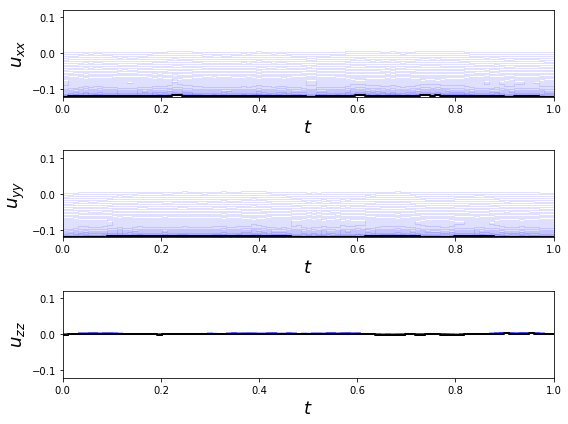

In [11]:
plot_grape_control_fields(times, result.u / (2 * np.pi), H_labels, uniform_axes=True);

In [12]:
# compare to the analytical results
np.mean(result.u[-1,0,:]), np.mean(result.u[-1,1,:]), np.pi/(4 * T)

(-0.74169008690613769, -0.74154800819245748, 0.7853981633974483)

## Fidelity

In [13]:
U

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+1.j  0.+0.j]
 [ 0.+0.j  0.+1.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j]]

In [14]:
result.U_f.tidyup(1e-2)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.99999812+0.j          0.00000000+0.j          0.00000000+0.j
   0.00000000+0.j        ]
 [ 0.00000000+0.j          0.09360401+0.j          0.00000000+0.99560763j
   0.00000000+0.j        ]
 [ 0.00000000+0.j          0.00000000+0.99560763j  0.09360401+0.j
   0.00000000+0.j        ]
 [ 0.00000000+0.j          0.00000000+0.j          0.00000000+0.j
   0.99999812+0.j        ]]

In [15]:
_overlap(U, result.U_f).real

0.9978028739003396

## Test numerical integration of GRAPE pulse

In [16]:
c_ops = []

In [17]:
U_f_numerical = propagator(result.H_t, times[-1], c_ops, args={})

In [18]:
U_f_numerical

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[  9.99938152e-01 +9.34327060e-03j   0.00000000e+00 +0.00000000e+00j
    0.00000000e+00 +0.00000000e+00j   5.63681404e-05 -6.03265085e-03j]
 [  0.00000000e+00 +0.00000000e+00j   6.01243551e-02 -5.61860409e-04j
    9.32654395e-03 +9.98147164e-01j   0.00000000e+00 +0.00000000e+00j]
 [  0.00000000e+00 +0.00000000e+00j   9.32654395e-03 +9.98147164e-01j
    6.01243551e-02 -5.61860409e-04j   0.00000000e+00 +0.00000000e+00j]
 [  5.63681404e-05 -6.03265085e-03j   0.00000000e+00 +0.00000000e+00j
    0.00000000e+00 +0.00000000e+00j   9.99938152e-01 +9.34327060e-03j]]

In [19]:
_overlap(U, U_f_numerical).real

0.9990426580571616

# Process tomography

## Ideal iSWAP gate

In [20]:
op_basis = [[qeye(2), sigmax(), sigmay(), sigmaz()]] * 2
op_label = [["i", "x", "y", "z"]] * 2

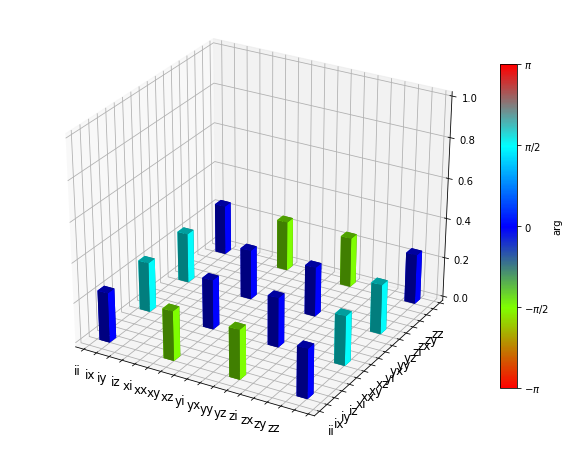

In [21]:
fig = plt.figure(figsize=(8,6))

U_ideal = spre(U) * spost(U.dag())

chi = qpt(U_ideal, op_basis)

fig = qpt_plot_combined(chi, op_label, fig=fig, threshold=0.001)

## iSWAP gate calculated using GRAPE

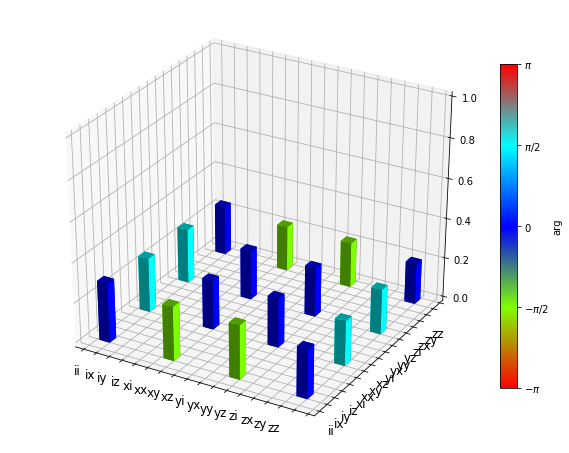

In [22]:
fig = plt.figure(figsize=(8,6))

U_ideal = to_super(result.U_f)

chi = qpt(U_ideal, op_basis)

fig = qpt_plot_combined(chi, op_label, fig=fig, threshold=0.001)

## Versions

In [23]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,4.2.0
Numpy,1.13.1
SciPy,0.19.1
matplotlib,2.0.2
Cython,0.25.2
Number of CPUs,2
BLAS Info,INTEL MKL
IPython,6.1.0
Python,"3.6.1 |Anaconda custom (x86_64)| (default, May 11 2017, 13:04:09) [GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]"
OS,posix [darwin]
